In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Generate data : I use the AWGN model to add noise

In [59]:
def awgn_channel(signal, snr_dB):
    """
    Caractérisation du bruit : Additive White Gaussian Noise
      "Additive" : on somme le bruit généré au signal
      "White" : Puissance du bruit uniforme sur toute la bande de fréquence. Cela fait référence à la densité spectrale 
      de puissance qui doit être uniforme
    """
    signal_power = np.mean(np.abs(signal) ** 2)
    snr = 10 ** (snr_dB / 10)  # Conversion du SNR en échelle linéaire
    noise_power = signal_power / snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power) # Distribution normale du bruit
    
    return signal + noise  

def generate_data(clean_signal, snr_dB):
    noisy_signal = awgn_channel(clean_signal, snr_dB)
    return noisy_signal

**Création d'un exemple de signal bruité :**

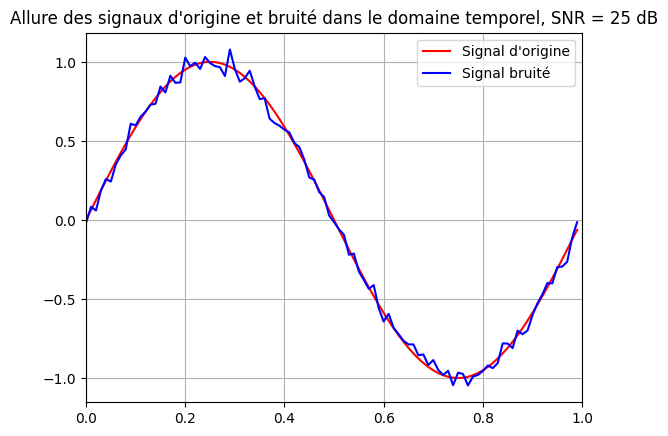

In [60]:
fe = 100
t = np.arange(0, 1, 1/fe)

clean_signal = np.sin(2 * np.pi * 1 * t) # Fréquence 1 Hz 
snr_dB = 25

noisy_signal = generate_data(clean_signal, snr_dB)
plt.plot(t, clean_signal, label = "Signal d'origine", color="r")
plt.plot(t, noisy_signal,label = "Signal bruité", color= "b")
plt.grid()
plt.title(f"Allure des signaux d'origine et bruité dans le domaine temporel, SNR = {snr_dB} dB")
plt.legend()
plt.xlim(0,1)
plt.show()

In [61]:
def generate_loaders(num_examples):
    fe = 100
    t = np.arange(0, 1, 1/fe)
    random_frequencies = np.random.uniform(1, 20, size=num_examples)
    
    clean_signals = np.sin(2 * np.pi * random_frequencies.reshape(-1, 1) * t)
    
    selected_snr_dB_levels = np.random.uniform(5,21, size=num_examples)
    noisy_signals = [awgn_channel(clean_signals[i], selected_snr_dB_levels[i]) for i in range(num_examples)]
    
    noisy_signals_tensor = torch.stack([torch.Tensor(noisy_signal) for noisy_signal in noisy_signals])
    clean_signals_tensor = torch.stack([torch.Tensor(clean_signal) for clean_signal in clean_signals])
    
    dataset = TensorDataset(noisy_signals_tensor, clean_signals_tensor)
    
    # Split Train 80 % / Validation 10 % / Test 10 %
    train_size = int(0.8 *  num_examples)  
    val_size = int(0.1 * num_examples)  
    test_size = num_examples - train_size - val_size  
    
    random_generator = torch.Generator().manual_seed(2504)
    train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[train_size, val_size, test_size], generator=random_generator)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader,val_loader,test_loader

### AutoEncoder Model : Denoising Autoencoder (DAE)

In [62]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(len(t), 1000),
            # nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(0.1)
            # nn.LSTM(50, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(500, len(t)),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Hyperparameters

In [63]:
num_epochs = 100
learning_rate = 0.0001
batch_size = 64
num_examples = 100000

In [64]:
train_loader,val_loader,test_loader = generate_loaders(num_examples)

In [65]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [66]:
for epoch in range(num_epochs):
    
    model.train()  
    for noisy_signals,clean_signals in train_loader:
        
        noisy_signals = noisy_signals.to(device)
        clean_signals = clean_signals.to(device)

        outputs = model(noisy_signals)

        loss = criterion(outputs, clean_signals)

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

    model.eval()
    val_loss = 0.0
    if epoch % 10 == 0:
        with torch.no_grad():
            for noisy_signals, clean_signals in val_loader:

                noisy_signals = noisy_signals.to(device)
                clean_signals = clean_signals.to(device)

                outputs = model(noisy_signals)

                val_loss += criterion(outputs, clean_signals)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

print('Training Complete')

Epoch [1/100], Training Loss: 0.0640, Validation Loss: 1.7689
Epoch [11/100], Training Loss: 0.0553, Validation Loss: 1.1036
Epoch [21/100], Training Loss: 0.0542, Validation Loss: 1.1394
Epoch [31/100], Training Loss: 0.0550, Validation Loss: 1.0589
Epoch [41/100], Training Loss: 0.0563, Validation Loss: 1.1783
Epoch [51/100], Training Loss: 0.0560, Validation Loss: 1.0411
Epoch [61/100], Training Loss: 0.0541, Validation Loss: 1.1140
Epoch [71/100], Training Loss: 0.0494, Validation Loss: 1.0202
Epoch [81/100], Training Loss: 0.0554, Validation Loss: 1.0761
Epoch [91/100], Training Loss: 0.0543, Validation Loss: 1.0283
Training Complete


In [67]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    
    for noisy_signals, clean_signals in test_loader:
    
        noisy_signals = noisy_signals.to(device)
        clean_signals = clean_signals.to(device)
        
        outputs = model(noisy_signals)
        
        test_loss += criterion(outputs, clean_signals)

print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 1.0908


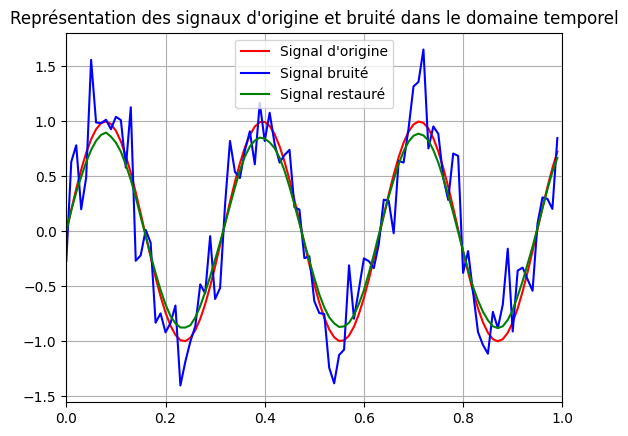

In [68]:
plt.plot(t, clean_signals[0].cpu(), label = "Signal d'origine", color="r")
plt.plot(t, noisy_signals[0].cpu(),label = "Signal bruité", color= "b")
plt.plot(t, outputs[0].cpu(),label = "Signal restauré", color= "g")
plt.grid()
plt.title("Représentation des signaux d'origine et bruité dans le domaine temporel")
plt.legend()
plt.xlim(0,1)
plt.show()